<a href="https://colab.research.google.com/github/u-masao/vector-search-tutorial-for-japanese/blob/main/Session02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 日本語のためのベクトル検索ハンズオン：Session 2

## 環境構築


### Google Colab 向け Docker インストール

In [1]:
# Copyright 2024 Drengskapur
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#
# @title {display-mode:"form"}
# @markdown <br/><br/><center><img src="https://cdn.jsdelivr.net/gh/drengskapur/docker-in-colab/assets/docker.svg" height="150"><img src="https://cdn.jsdelivr.net/gh/drengskapur/docker-in-colab/assets/colab.svg" height="150"></center><br/>
# @markdown <center><h1>Docker in Colab</h1></center><center>github.com/drengskapur/docker-in-colab<br/><br/><br/><b>udocker("run hello-world")</b></center><br/>
def udocker_init():
    import os
    if not os.path.exists("/home/user"):
        !pip install udocker > /dev/null
        !udocker --allow-root install > /dev/null
        !useradd -m user > /dev/null
    print(f'Docker-in-Colab 1.1.0\n')
    print(f'Usage:     udocker("--help")')
    print(f'Examples:  https://github.com/indigo-dc/udocker?tab=readme-ov-file#examples')

    def execute(command: str):
        user_prompt = "\033[1;32muser@pc\033[0m"
        print(f"{user_prompt}$ udocker {command}")
        !su - user -c "udocker $command"

    return execute

udocker = udocker_init()

Docker-in-Colab 1.1.0

Usage:     udocker("--help")
Examples:  https://github.com/indigo-dc/udocker?tab=readme-ov-file#examples


In [2]:
# udocker("pull qdrant/qdrant")

In [3]:
udocker("run -d -p 127.0.0.1:6333:6333 -p 127.0.0.1:6334:6334 qdrant/qdrant")

user@pc$ udocker run -d -p 127.0.0.1:6333:6333 -p 127.0.0.1:6334:6334 qdrant/qdrant
Error: syntax error at: -d


###  SageMaker 向け docker インストール

(省略)

## パッケージのインストールと読み込み

In [62]:
!pip install -q qdrant-client
!pip install -q japanize_matplotlib
!pip install -q sentence-transformers
!pip install -q torchsummary


In [5]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np

## Qdrant の利用

In [6]:
from qdrant_client import QdrantClient

qdrant_url = "http://localhost:6333"
qdrant_collection_name = "test_collection"

client = QdrantClient(url=qdrant_url)

In [7]:
status = client.get_collection(
    collection_name=qdrant_collection_name,
)

print(status)

status = client.delete_collection(
    collection_name=qdrant_collection_name,
)

print(status)

status=<CollectionStatus.GREEN: 'green'> optimizer_status=<OptimizersStatusOneOf.OK: 'ok'> vectors_count=6 indexed_vectors_count=0 points_count=6 segments_count=2 config=CollectionConfig(params=CollectionParams(vectors=VectorParams(size=4, distance=<Distance.DOT: 'Dot'>, hnsw_config=None, quantization_config=None, on_disk=None), shard_number=1, sharding_method=None, replication_factor=1, write_consistency_factor=1, read_fan_out_factor=None, on_disk_payload=True, sparse_vectors=None), hnsw_config=HnswConfig(m=16, ef_construct=100, full_scan_threshold=10000, max_indexing_threads=0, on_disk=False, payload_m=None), optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segment_number=0, max_segment_size=None, memmap_threshold=None, indexing_threshold=20000, flush_interval_sec=5, max_optimization_threads=None), wal_config=WalConfig(wal_capacity_mb=32, wal_segments_ahead=0), quantization_config=None) payload_schema={}
True


In [8]:
from qdrant_client.models import Distance, VectorParams

client.create_collection(
    collection_name=qdrant_collection_name,
    vectors_config=VectorParams(size=4, distance=Distance.DOT),
)

True

In [9]:
from qdrant_client.models import PointStruct

operation_info = client.upsert(
    collection_name=qdrant_collection_name,
    wait=True,
    points=[
        PointStruct(id=1, vector=[0.05, 0.61, 0.76, 0.74], payload={"city": "Berlin"}),
        PointStruct(id=2, vector=[0.19, 0.81, 0.75, 0.11], payload={"city": "London"}),
        PointStruct(id=3, vector=[0.36, 0.55, 0.47, 0.94], payload={"city": "Moscow"}),
        PointStruct(id=4, vector=[0.18, 0.01, 0.85, 0.80], payload={"city": "New York"}),
        PointStruct(id=5, vector=[0.24, 0.18, 0.22, 0.44], payload={"city": "Beijing"}),
        PointStruct(id=6, vector=[0.35, 0.08, 0.11, 0.44], payload={"city": "Mumbai"}),
    ],
)

print(operation_info)

operation_id=0 status=<UpdateStatus.COMPLETED: 'completed'>


In [10]:
search_result = client.search(
    collection_name=qdrant_collection_name,
    query_vector=[0.2, 0.1, 0.9, 0.7],
    limit=3
)

_ = [print(x) for x in search_result]

id=4 version=0 score=1.362 payload={'city': 'New York'} vector=None shard_key=None
id=1 version=0 score=1.273 payload={'city': 'Berlin'} vector=None shard_key=None
id=3 version=0 score=1.208 payload={'city': 'Moscow'} vector=None shard_key=None


In [11]:
from qdrant_client.models import Filter, FieldCondition, MatchValue

search_result = client.search(
    collection_name=qdrant_collection_name,
    query_vector=[0.2, 0.1, 0.9, 0.7],
    query_filter=Filter(
        must=[FieldCondition(key="city", match=MatchValue(value="London"))]
    ),
    with_payload=True,
    limit=3,
)

_ = [print(x) for x in search_result]

id=2 version=0 score=0.871 payload={'city': 'London'} vector=None shard_key=None


## 埋め込みモデルの利用


### モデル

![HuggingFace](https://huggingface.co/datasets/huggingface/brand-assets/resolve/main/hf-logo-with-title.png)

HuggingFace のモデルが使いやすい。

- 日本語対応の Sentence Similarity モデルの一覧(日々更新される)

    - [モデル検索ページ](https://huggingface.co/models?pipeline_tag=sentence-similarity&language=ja&sort=trending)

In [12]:

item_df = pd.DataFrame([
    {'id':10, 'theme':'自転と公転', 'text':'地球は自転しており、24時間で一回転します。これにより日夜が発生します。また、地球は太陽の周りを365日で一周する公転もしており、これが季節の変化を引き起こします。',},
    {'id':11, 'theme':'自転と公転', 'text':'地球の自転により、一日の長さが決まり、夜と昼が交互にやってきます。公転は太陽の周りの一周で、約一年かかり、四季の移り変わりの原因となります。',},
    {'id':12, 'theme':'自転と公転', 'text':'自転とは地球が自軸を中心に一日で一回転することで、日の出と日の入りが生じます。公転は地球が太陽の周囲を約365日かけて一周し、季節の変動をもたらします。',},
    {'id':13, 'theme':'自転と公転', 'text':'地球はその軸を中心に自転し、それが24時間周期の昼夜を生み出しています。一方で、地球は太陽の周りを公転し、この動きが年間を通じて気候の変化を引き起こす季節変動を生成します。',},
    {'id':20, 'theme':'メトロノームの効能', 'text':'メトロノームを使うことでリズム感が養われ、一定のテンポで正確に演奏する練習ができます。これは音楽の演奏技術向上に非常に役立ちます。',},
    {'id':21, 'theme':'メトロノームの効能', 'text':'メトロノームを使用することで、音楽演奏時のテンポの維持が容易になります。これにより、演奏の一貫性と精度が向上します。',},
    {'id':22, 'theme':'メトロノームの効能', 'text':'メトロノームは演奏者がリズムを厳密に守ることを助け、特にグループでの演奏において同期を取るのに役立ちます。このツールは練習時の集中力も高めます。',},
    {'id':23, 'theme':'メトロノームの効能', 'text':'メトロノームを利用すると、演奏中のテンポを客観的に把握でき、リズムのぶれを修正するのに有効です。これにより、よりプロフェッショナルな演奏技術を身につけることができます。',},
]).set_index('id')

item_df

,theme,text
id,,
10,自転と公転,地球は自転しており、24時間で一回転します。これにより日夜が発生します。また、地球は太陽の周...
11,自転と公転,地球の自転により、一日の長さが決まり、夜と昼が交互にやってきます。公転は太陽の周りの一周で、...
12,自転と公転,自転とは地球が自軸を中心に一日で一回転することで、日の出と日の入りが生じます。公転は地球が太...
13,自転と公転,地球はその軸を中心に自転し、それが24時間周期の昼夜を生み出しています。一方で、地球は太陽の...
20,メトロノームの効能,メトロノームを使うことでリズム感が養われ、一定のテンポで正確に演奏する練習ができます。これは...
21,メトロノームの効能,メトロノームを使用することで、音楽演奏時のテンポの維持が容易になります。これにより、演奏の一...
22,メトロノームの効能,メトロノームは演奏者がリズムを厳密に守ることを助け、特にグループでの演奏において同期を取るの...
23,メトロノームの効能,メトロノームを利用すると、演奏中のテンポを客観的に把握でき、リズムのぶれを修正するのに有効で...


In [13]:
# 基本的な使い方

# モデル名を定義(HuggingFaceのモデル名)
model_name = "intfloat/multilingual-e5-small"

# 埋め込みモデルを初期化
model = SentenceTransformer(model_name)

# 埋め込みベクトルの取得
embeddings = model.encode(item_df['text'].values)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [14]:
# 返り値の型
print(type(embeddings))

<class 'numpy.ndarray'>


In [15]:
# 形状
print(embeddings.shape)

(8, 384)


In [16]:
# ベクトルの大きさ
print(np.linalg.norm(embeddings[0].tolist(), ord=2))

0.99999998427664


In [17]:
# ベクトルの数値
print(embeddings[0])

[ 0.07265533 -0.02737279 -0.02342032 -0.07276566  0.11036015 -0.0119391
 -0.01391273  0.04546628  0.10458223  0.01869721  0.0144851  -0.02732359
  0.04394547  0.02587822 -0.04370999  0.0263737   0.05032514 -0.06193559
  0.01469676 -0.03283325  0.01529458  0.04244423 -0.07038571  0.07879799
  0.0586671   0.06745208 -0.00624266  0.07424284  0.04060534 -0.07351615
 -0.03221299 -0.06772496  0.02450223 -0.05059789  0.05979783  0.02648341
 -0.01048144 -0.06466465  0.06472722 -0.07025819  0.00574615  0.00927107
  0.0346462   0.03380042  0.0218608   0.1355815  -0.05699701  0.04978235
 -0.04721194 -0.01302735 -0.03295247  0.02687644  0.03764228  0.04538498
  0.02094763 -0.08717156 -0.0390455  -0.07496147 -0.07391667  0.09129124
  0.08788916  0.02345508  0.02238471  0.05904458  0.10307614  0.05671706
  0.01734488  0.0543476   0.00632273 -0.05239816 -0.05650188  0.05657195
  0.00556469  0.00760487 -0.01195665  0.04927867  0.0324344  -0.03626872
  0.01064984 -0.03092819 -0.05623312 -0.03095022 -0.

In [18]:
# コサインを計算する関数を定義
def cosine(vec_a, vec_b):
    l2norm_a = np.linalg.norm(vec_a, ord=2)
    l2norm_b = np.linalg.norm(vec_b, ord=2)
    return (vec_a @ vec_b) / (l2norm_a * l2norm_b)

similarity_matrix = {}
for x in range(len(item_df)):
    row = {}
    for y in range(len(item_df)):
        row[item_df.iloc[y].name]=cosine(embeddings[x], embeddings[y])
    similarity_matrix[item_df.iloc[x].name] = row

similarity_df =pd.DataFrame(similarity_matrix)
similarity_df

,10,11,12,13,20,21,22,23
10,1.000000,0.958078,0.950788,0.960311,0.795296,0.785270,0.773369,0.782573
11,0.958078,1.000000,0.961488,0.939677,0.802750,0.792080,0.780250,0.786090
12,0.950788,0.961488,1.000000,0.937830,0.777413,0.769831,0.755127,0.760393
13,0.960311,0.939677,0.937830,1.000000,0.797479,0.788939,0.776972,0.785247
20,0.795296,0.802750,0.777413,0.797479,1.000000,0.979591,0.962964,0.975847
21,0.785270,0.792080,0.769831,0.788939,0.979591,1.000000,0.955072,0.969912
22,0.773369,0.780250,0.755127,0.776972,0.962964,0.955072,1.000000,0.946316
23,0.782573,0.786090,0.760393,0.785247,0.975847,0.969912,0.946316,1.000000


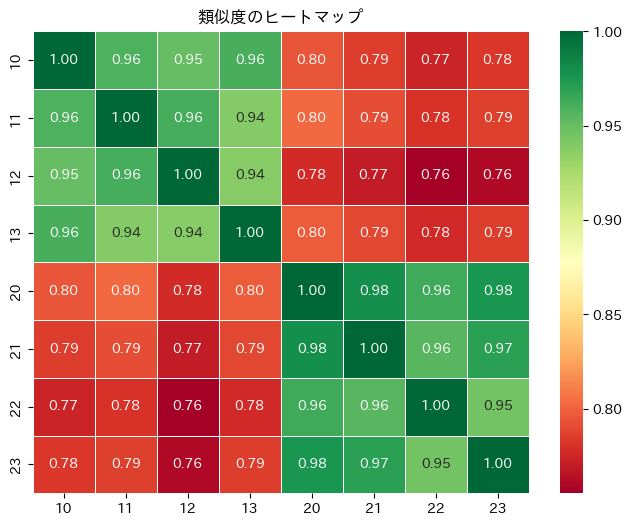

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

# ヒートマップで表示
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(similarity_df, annot=True, cmap='RdYlGn', linewidths=.5, fmt=".2f", ax=ax)
ax.set_title("類似度のヒートマップ")
fig.show()

## 埋め込みプロセスの詳細

In [20]:
import torch.nn.functional as F

from torch import Tensor
from transformers import AutoTokenizer, AutoModel


# 最終隠れ層に対するアベレージプーリング関数を定義
def average_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]


# トークナイザーの初期化
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 埋め込みモデルの初期化
embedding_model = AutoModel.from_pretrained(model_name)

In [21]:
# 埋め込み対象文字列を定義
texts = [
    '吾輩は猫である。名前はまだ無い。',
    '私は生まれたばかりの猫です。まだ名前を決めていないのです。',
    '線形代数学と幾何学と位相空間論を学ぶ学生さんの素敵な日常',
    'ベクトルデータベースは、深層学習アーキテクチャなどの不透明な機械学習モデルから派生した抽象データ表現を操作するための比較的新しい方法です。',
]

In [22]:
# トークナイズ
batch_dict = tokenizer(texts, max_length=512, padding=True, truncation=True, return_tensors='pt')

In [23]:
# 埋め込みモデルで処理
outputs = embedding_model(**batch_dict)

In [24]:
# アベレージプーリングで最終隠れ層をサマライズ
item_embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])

In [26]:
from torch.nn import CosineSimilarity

cos = CosineSimilarity(dim=0)
scores = {}
for i in range(len(texts)):
    row = {}
    for j in range(len(texts)):
        row[j] = cos(item_embeddings[i], item_embeddings[j]).item()
    scores[i] = row
score_df = pd.DataFrame(scores)
score_df

,0,1,2,3
0,1.000000,0.886615,0.794468,0.746712
1,0.886615,1.000000,0.814253,0.796628
2,0.794468,0.814253,1.000000,0.797136
3,0.746712,0.796628,0.797136,1.000000


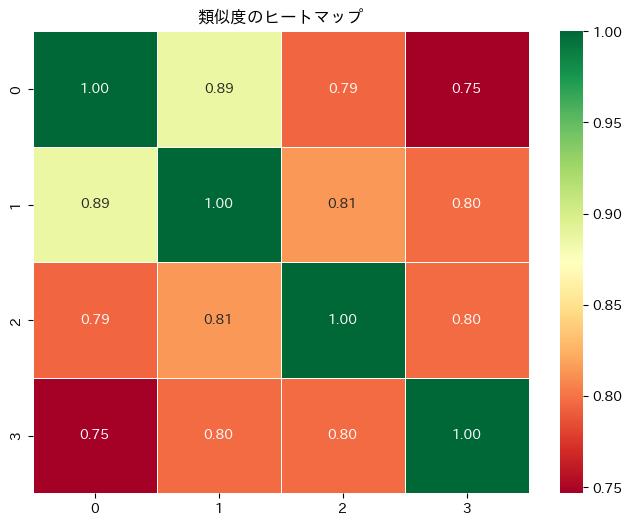

In [27]:
# ヒートマップで表示
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(score_df, annot=True, cmap='RdYlGn', linewidths=.5, fmt=".2f", ax=ax)
ax.set_title("類似度のヒートマップ")
fig.show()

### トークナイザー

In [47]:
help(tokenizer)

Help on XLMRobertaTokenizerFast in module transformers.models.xlm_roberta.tokenization_xlm_roberta_fast object:

class XLMRobertaTokenizerFast(transformers.tokenization_utils_fast.PreTrainedTokenizerFast)
 |  XLMRobertaTokenizerFast(vocab_file=None, tokenizer_file=None, bos_token='<s>', eos_token='</s>', sep_token='</s>', cls_token='<s>', unk_token='<unk>', pad_token='<pad>', mask_token='<mask>', **kwargs)
 |  
 |  Construct a "fast" XLM-RoBERTa tokenizer (backed by HuggingFace's *tokenizers* library). Adapted from
 |  [`RobertaTokenizer`] and [`XLNetTokenizer`]. Based on
 |  [BPE](https://huggingface.co/docs/tokenizers/python/latest/components.html?highlight=BPE#models).
 |  
 |  This tokenizer inherits from [`PreTrainedTokenizerFast`] which contains most of the main methods. Users should
 |  refer to this superclass for more information regarding those methods.
 |  
 |  Args:
 |      vocab_file (`str`):
 |          Path to the vocabulary file.
 |      bos_token (`str`, *optional*, de

In [50]:
batch_dict

{'input_ids': tensor([[     0,      6, 166400, 109055,    342,  35076,   8929,     30,  65610,
         150245, 125151,     30,      2,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1],
        [     0,  65579, 205146,  52373,    154,  35076,   1453,     30,  33798,
          65610,    251,  78462,  88914,  12079,     30,      2,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1],
        [     0,      6,   5051,   9378,   5260,  78791,    610,  15818,   4931,
           4058,    610,   3803,   4791,  20534,  26700,    251, 166502,   7252,
          35275, 127973,  34413,      2,      1,      1,      1,      1,    

In [36]:
batch_dict['input_ids'][0]

tensor([     0,      6, 166400, 109055,    342,  35076,   8929,     30,  65610,
        150245, 125151,     30,      2,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1])

In [52]:
print(tokenizer.decode(batch_dict['input_ids'][0][2]))

吾


In [53]:
tokenizer.decode(batch_dict['input_ids'][0])

'<s> 吾輩は猫である。名前はまだ無い。</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'

In [54]:
for token in batch_dict['input_ids'][3]:
    if token != 1:
        print(token.item(), tokenizer.decode(token))

0 <s>
6 
43339 ベ
4758 ク
128346 トル
45465 データ
146509 ベース
342 は
37 、
6728 深
14967 層
107528 学習
135745 アー
14323 キ
19827 テ
4758 ク
58440 チャ
18009 などの
562 不
56896 透明
1308 な
50866 機械
107528 学習
91191 モデル
1309 から
10356 派
2026 生
2419 した
198286 抽象
45465 データ
23014 表現
251 を
13160 操作
124481 するための
9455 比較
43 的
38851 新しい
5796 方法
1453 です
30 。
2 </s>


### 埋め込みモデルのアウトプット

In [55]:
outputs

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.3479, -0.0181, -0.0715,  ...,  0.2091,  0.2447,  0.0107],
         [ 0.3096,  0.0174,  0.1258,  ..., -0.0620,  0.6459,  0.2021],
         [ 0.3759, -0.0167, -0.1307,  ...,  0.2724,  0.4138,  0.1373],
         ...,
         [ 0.4231, -0.0478, -0.0198,  ...,  0.2971,  0.4338,  0.0908],
         [ 0.4239, -0.0471, -0.0084,  ...,  0.3011,  0.4194,  0.0868],
         [ 0.4208, -0.0381,  0.0034,  ...,  0.2956,  0.4054,  0.0833]],

        [[ 0.1932, -0.0650, -0.0761,  ...,  0.2749,  0.0963,  0.0708],
         [ 0.1157, -0.1209,  0.0304,  ...,  0.3498,  0.2150,  0.3116],
         [ 0.0020, -0.0326,  0.0157,  ...,  0.4358,  0.1509,  0.2240],
         ...,
         [ 0.1853, -0.0929, -0.1003,  ...,  0.3886,  0.0729,  0.1668],
         [ 0.1899, -0.0822, -0.0800,  ...,  0.3870,  0.0614,  0.1527],
         [ 0.1806, -0.0829, -0.0610,  ...,  0.3936,  0.0312,  0.1479]],

        [[ 0.2402,  0.0094, -0.1539,  ...,  0.0759,  

In [56]:
dir(outputs)


['__annotations__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__ior__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__or__',
 '__post_init__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__ror__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'attentions',
 'clear',
 'copy',
 'cross_attentions',
 'fromkeys',
 'get',
 'hidden_states',
 'items',
 'keys',
 'last_hidden_state',
 'move_to_end',
 'past_key_values',
 'pooler_output',
 'pop',
 'popitem',
 'setdefault',
 'to_tuple',
 'update',
 'values']

In [59]:
outputs

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.3479, -0.0181, -0.0715,  ...,  0.2091,  0.2447,  0.0107],
         [ 0.3096,  0.0174,  0.1258,  ..., -0.0620,  0.6459,  0.2021],
         [ 0.3759, -0.0167, -0.1307,  ...,  0.2724,  0.4138,  0.1373],
         ...,
         [ 0.4231, -0.0478, -0.0198,  ...,  0.2971,  0.4338,  0.0908],
         [ 0.4239, -0.0471, -0.0084,  ...,  0.3011,  0.4194,  0.0868],
         [ 0.4208, -0.0381,  0.0034,  ...,  0.2956,  0.4054,  0.0833]],

        [[ 0.1932, -0.0650, -0.0761,  ...,  0.2749,  0.0963,  0.0708],
         [ 0.1157, -0.1209,  0.0304,  ...,  0.3498,  0.2150,  0.3116],
         [ 0.0020, -0.0326,  0.0157,  ...,  0.4358,  0.1509,  0.2240],
         ...,
         [ 0.1853, -0.0929, -0.1003,  ...,  0.3886,  0.0729,  0.1668],
         [ 0.1899, -0.0822, -0.0800,  ...,  0.3870,  0.0614,  0.1527],
         [ 0.1806, -0.0829, -0.0610,  ...,  0.3936,  0.0312,  0.1479]],

        [[ 0.2402,  0.0094, -0.1539,  ...,  0.0759,  

In [60]:
embedding_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(250037, 384, padding_idx=0)
    (position_embeddings): Embedding(512, 384)
    (token_type_embeddings): Embedding(2, 384)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

In [61]:
dir(embedding_model)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_auto_class',
 '_autoset_attn_implementation',
 '_backward_compatibility_gradient_checkpointing',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_check_and_enable_flash_attn_2',
 '_check_and_enable_sdpa',
 '_compiled_call_impl',
 '_convert_head_mask_to_5d',
 '_copy_lm_head_original_to_resized',
 '_create_repo',
 '_dispatch_accelerate_model',
 '_expand_inputs_for_generation',
 '_extract_past_from_model_output',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_k

In [73]:
type(embedding_model)

transformers.models.bert.modeling_bert.BertModel

In [76]:
type(tokenizer)

transformers.models.xlm_roberta.tokenization_xlm_roberta_fast.XLMRobertaTokenizerFast

In [77]:
tokenizer

XLMRobertaTokenizerFast(name_or_path='intfloat/multilingual-e5-small', vocab_size=250002, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	250001: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [78]:
dir(tokenizer)

['SPECIAL_TOKENS_ATTRIBUTES',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_tokens',
 '_additional_special_tokens',
 '_auto_class',
 '_batch_encode_plus',
 '_bos_token',
 '_call_one',
 '_cls_token',
 '_compile_jinja_template',
 '_convert_encoding',
 '_convert_id_to_token',
 '_convert_token_to_id_with_added_voc',
 '_create_repo',
 '_decode',
 '_decode_use_source_tokenizer',
 '_encode_plus',
 '_eos_token',
 '_eventual_warn_about_too_long_sequence',
 '_eventually_correct_t5_max_length',
 '_from_pretrained',
 '_get_files_timestamps',
 '_get_padding_truncation_strategies',
 '_in_target_context_manager',
 '_mask_token',
 '

In [83]:
vocab=tokenizer.get_vocab()

In [85]:

len(vocab)

250002

In [86]:

type(vocab)

dict

In [96]:
vocab=sorted(vocab)

In [103]:
start=226_000
vocab[start:start+100]

['いること',
 'いると',
 'いるの',
 'いるのか',
 'いるので',
 'いれば',
 'いろいろ',
 'いろいろな',
 'いろんな',
 'いわゆる',
 'ぅ',
 'う',
 'うえで',
 'うこと',
 'うち',
 'うちに',
 'うちの',
 'うまく',
 'うれしい',
 'ぇ',
 'え',
 'えた',
 'えて',
 'えない',
 'えば',
 'えます',
 'える',
 'ぉ',
 'お',
 'おい',
 'おいしい',
 'おいて',
 'おう',
 'おか',
 'おかげで',
 'おき',
 'おきたい',
 'おきましょう',
 'おしゃれ',
 'おすすめ',
 'おすすめです',
 'おすすめの',
 'おそらく',
 'おっしゃ',
 'およそ',
 'および',
 'おり',
 'おります',
 'お世話',
 'お互い',
 'お仕事',
 'お休み',
 'お会い',
 'お伝え',
 'お使い',
 'お勧め',
 'お友達',
 'お問い合わせ',
 'お問い合わせください',
 'お問合せ',
 'お土産',
 'お子さん',
 'お子様',
 'お客さま',
 'お客さん',
 'お客様',
 'お客様に',
 'お客様の',
 'お届け',
 'お店',
 'お弁当',
 'お待ち',
 'お待ちしております',
 'お得',
 'お得な',
 'お悩み',
 'お手伝い',
 'お支払い',
 'お楽しみ',
 'お母さん',
 'お気に入り',
 'お気軽に',
 'お申し込み',
 'お申込み',
 'お知らせ',
 'お祝い',
 'お肌',
 'お腹',
 'お茶',
 'お菓子',
 'お試し',
 'お話',
 'お越し',
 'お送り',
 'お酒',
 'お金',
 'お金を',
 'お電話',
 'お願い',
 'お願いいたします']